# 第14回 生成AI入門

___
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tsuboshun/begin-python/blob/gh-pages/2024/workbook/lecture14.ipynb)

___

## この授業で学ぶこと

**生成AI**とは、文章、画像、動画、音声といった様々なデータから学習し、それらの新しいデータを生み出すことができるAIのことを言う。

例えば、
- 「夕日に染まる海辺でたたずむ猫」という文章から、写真のようなリアルな画像を生成したり
- 数小節のメロディーを入力するだけで、続きの曲を自動で作曲したり
- 自分の代わりに、メールの文章を作成したり
- 会議の内容を要約して、議事録を作成したり

といったことが生成AIでできるようになってきている。

最近ではChatGPTという、まるで人間と話しているかのように自然な文章を生成するAIが登場し、世界中で大きな話題となっている。

生成AIは日々進化を続けており、次々と新しい技術やサービスが登場している。しかし、その基本的な仕組みは当初から大きく変わっていないし、また今後しばらく変わらないと見られている。生成AIを上手に活用したり、今後の技術的な進展を予想したりするためにも、基本的な仕組みを理解しておくことはとても重要である。

今回は、生成AIの仕組みの概要を理解し、さらにPythonプログラムから生成AIを使えるようになることを目標に授業する。なるべく話を簡単にするため、**言語モデル**と呼ばれる、文章を入力して文章を出力するタイプの生成AIを主に扱う。

## 生成モデル

生成AIは、**生成モデル**と呼ばれる技術により実現されている。
生成モデルは魔法の箱のようなもので、入力を与えるとそれに応じて人間にとって望ましい出力を、確率的かつ直接的に出力することができる。

### 条件付き確率

生成モデルの仕組みを理解するために、条件付き確率という考え方が重要になる。例えば、とある小売店のとある日におけるアイスクリームの売上個数の確率を考えたいとしよう。
アイスクリームの売上個数の確率分布は、その日の気温に応じて変化すると考えられる。
このような条件に応じた確率分布を表現するのが**条件付き確率分布**で、次のような書き方をする。

$p(アイスクリームの売上個数 | 気温)$

これは「気温」と「アイスクリームの売上個数」のところに数値を入れると、確率を表す数値が返ってくるような関数となっている。例えば、このお店ではアイスクリームを3個しか仕入れていないとして、気温が27度という条件のもとでの確率の例をこの形式で表すと、以下のようになる（見やすさのため、ここでは $\rightarrow$ で戻り値を表す）。
- $p(アイスクリームの売上個数 = 0| 気温 = 27) \rightarrow 0.1$
- $p(アイスクリームの売上個数 = 1| 気温 = 27) \rightarrow 0.2$
- $p(アイスクリームの売上個数 = 2| 気温 = 27) \rightarrow 0.6$
- $p(アイスクリームの売上個数 = 3| 気温 = 27) \rightarrow 0.1$

気温が10度という条件のもとでの確率は、例えば以下のようになるだろう。
- $p(アイスクリームの売上個数 = 0| 気温 = 10) \rightarrow 0.8$
- $p(アイスクリームの売上個数 = 1| 気温 = 10) \rightarrow 0.2$
- $p(アイスクリームの売上個数 = 2| 気温 = 10) \rightarrow 0$
- $p(アイスクリームの売上個数 = 3| 気温 = 10) \rightarrow 0$

生成モデルも、これと同じように条件付き確率分布で表現することができる。

$p( y | x )$
- $y$: 生成モデルが出力するデータ
- $x$: 生成モデルに入力するデータ 

これは「入力データ $x$」が与えられたという条件のもとで、「出力データ $y$」が生成される確率を表している。
生成モデルは、この確率分布にしたがって出力データを確率的に生成する。
この確率分布が人間にとって便利な形になっていることが、生成モデルが便利なツールとなっている所以である。

### パラメータ

生成モデルは、**パラメータ**と呼ばれる値により、出力結果を調整できるように設計されている。
例えば、先ほどのアイスの例で考えると「アイスの値段」や「湿度」といった要素も、売上個数の確率に影響を与えるかもしれない。
これらのパラメータを $\bf\theta$ と表して、生成モデルの式に明示的に含めることにすれば、先ほどの式は以下のように書き直すことができる。

$p(y | x;\theta)$
- $\bf\theta$: 生成モデルのパラメータ

この式は $x$ だけではなく $\theta$ の値にも依存して、$y$ の確率分布が変わることを意味している。

パラメータを含むモデルの簡単な例として、**単回帰モデル**がある。単回帰モデルは以下のように2つのパラメータ $a$、$b$ を持つ関数として表される。

$y = ax + b$
- $y$: 出力
- $x$: 入力
- $a, b$: パラメータ 

この式は確率的ではなく、入力 $x$ に対して一つの出力 $y$ を定める決定的な式である。そのため、単回帰モデルは通常、生成モデルとは言わない。
しかし、$y$ について $ax + b$ に確率 $1$ を割り当て、それ以外の値に確率 $0$ を割り当てていると考えれば、生成モデルの一例と見なすこともできる。

### 言語モデル

さて、生成モデルの一つである言語モデルについて、生成方法を詳しく見てみよう。なお、言語モデルの中でも膨大な数のパラメータを持ち、膨大なデータを使って学習されるものを**大規模言語モデル** （**Large Language Model, LLM**）という。例えば、ChatGPTの内部では**GPT**（**Generative Pre-trained Transformer**）という大規模言語モデルが使われている。最新のモデルであるGPT-4oの詳細は公開されていないが、一世代前のGPT-3については詳細が公開されているので、適宜GPT-3の仕様を紹介しながら言語モデルについて解説する。以降では、基本的に大規模言語モデルを指して、言語モデルという言葉を使う。

言語モデルは文章全体を一度に生成するのではなく、**トークン**と呼ばれる単位で順番に生成する。おおよそ英語の場合には単語、日本語の場合には文字の単位をトークンとしている[^f1]。

[^f1]: 実際には英語で単語の一部分からなるトークンがあったり、日本語で複数の文字の組み合わせからなるトークンがあったりするが、理解を簡単にするためにこのように説明している。

したがって、言語モデルは文章 $x$ を入力として、次のトークン $w$ を出力するモデル $p(w | x;\theta)$ と表現できる。なお、文章 $x$ も入力時にトークンに分割して、トークンを並べたものとして入力される。そして、条件付き確率分布にしたがってトークン $w_1$ を出力したら、$x$ と $w_1$ を連結した $xw_1$ を再度入力して次のトークン $w_2$ を出力する。
$xw_1w_2$ を再度入力して $w_3$ を出力し...という操作を、終端を表すトークンが出力されるまで繰り返すことで、任意の長さの文章 $y = w_1w_2\cdots w_n$ を生成することができる。

例えば、言語モデルに「以下を英訳して：私の名前は春子です。」という文章を入力した場合を考えてみよう。ChatGPTなどでこの文章を入力すると、例えば「My name is Haruko.」と返ってくる。このとき内部では以下のような手順で文章が生成される。

```{figure} ./pic/language-model.png
---
width: 800px
name: language-model
---
言語モデルの生成過程
```

まず、文章はトークンに分割されてから言語モデルに入力される。ここで各トークンは、GPT-3の場合、長さ50257の数値からなる配列（数学的には50257次元のベクトルという）として表現される。各インデックスが1つのトークンと一対一で対応しており、各トークンは自身を表すインデックスの要素のみ 1 でそれ以外の要素が全て 0 という**one-hotベクトル**（つまり $[0, ..., 0, 1, 0, ..., 0]$ という配列）として表現される。

そして言語モデルにこの配列の並び（つまり2次元配列）を入力すると、GPT-3の場合は長さ50257の配列が出力される。これはトークン上の確率分布を表しており、この確率分布にしたがって出力トークンが決定される。この例では「I」または「My」に対応する値が大きくなっており、それを反映して「My」と出力されている。確率的なので必ずしも最大値に対応するトークンが出力されるわけではないことに注意しよう。

次に言語モデルに「以下を英訳して：私の名前は春子です。My」が入力され、同様に長さ50257の配列が出力される。今回は「name」に対応する値が大きくなっており、それを反映して「name」と出力されている。これを繰り返すことで文章を生成することができる。

ここまでの説明から示唆されるように、言語モデルはプログラムとしては「数値の配列を入力して数値の配列を出力するパラメータ付きの関数」になっている。
この関数として、最近の言語モデルでは主に**Transformer**モデルが使われている[^f2]。Transformerのパラメータ数は膨大であり、例えばGPT-3の総パラメータ数は約1750億個となっている。

言語モデルの性能は、これら膨大な数のパラメータの値によって決まる。例えば、ランダムな値をパラメータとして設定すれば、ランダムなトークンを生成するだろう。したがって、言語モデルが便利なツールとなるように、パラメータの値をどのように設定するかが問題になる。

[^f2]: Transformerの詳細が気になる方には、こちらの解説動画をお勧めする：[解説動画1](https://youtu.be/wjZofJX0v4M?si=A266N3VMzHLVkcd3)、[解説動画2](https://youtu.be/eMlx5fFNoYc?si=Y9j7yx0pGnrnXXqr)

## 学習

モデルの出力が望ましいものになるように、データをもとにモデルのパラメータを求める過程を**学習**という。言語モデルを含む近年のほとんどの**深層学習モデル**（膨大な数のパラメータを持つモデル）の学習には、**勾配法**という手法が用いられている。ここでは、勾配法の最もシンプルな場合について単回帰モデルを使って解説し、その後、言語モデルの学習方法を解説する。

### 勾配法

第11回でも扱った $y = 2x + \varepsilon$ の関係を満たす2次元データ $(x, y)$ 100個が手元にあったとする。
ここで $\varepsilon$ は平均 $0$、標準偏差 $1$ の正規分布に従うノイズとする。
これらの $x$ と $y$ の関係を予測する単回帰モデル $y = ax + b$ のパラメータ $a$、$b$ を勾配法によって求めてみよう[^f3]。

はじめに $a$ と $b$ にはランダムな値が設定されていたとする。このときのデータと $y = ax + b$ の関係を下図の左にプロットする。

[^f3]: もちろん私たちは生成式を知っているので、およそ $a = 2$、$b = 0$ が正解と予想できるが、ここでは生成式を知らなかったという体で話をしている。また単回帰モデルは簡単なモデルなので、$a$ と $b$ の解析解（データから直接求める計算式）が存在するが、ここでは説明のためあえて勾配法を使っている。

In [ ]:
pip install japanize_matplotlib

In [1]:
import random
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np

from ipywidgets import Button, VBox, Layout, Output
from IPython.display import display
plt.rcParams.update({'font.size': 14})  # 文字サイズを14pxとする

# 0から10までの0.1刻みの配列
x = np.arange(0, 10, 0.1)

# y = 2x + eps　（epsはノイズ）
eps = np.random.normal(loc=0, scale=1, size=len(x))
y = x * 2 + eps


class LinearModel:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    def predict(self, x):
        return self.a * x + self.b

    def perturb(self, da, db):
        return LinearModel(self.a + da, self.b + db)

def loss(x, y, model):
    return np.sum((y - model.predict(x)) ** 2) / len(x)

In [2]:
plot_output = Output()
model = LinearModel(2*random.random()-1, 2*random.random()-1)
a_list = [model.a]
b_list = [model.b]


def update_param(event=None):
    """勾配法によりモデルのパラメータを更新する
    """
    global model, a_list, b_list
    with plot_output:
        d = 10 ** (-4)  # 勾配を計算するための微小変化
        alpha = 10 ** (-2)  # 学習率 （勾配の方向にパラメータをどれくらい動かすか）
        
        grad_a = (loss(x, y, model.perturb(d, 0)) - loss(x, y, model)) / d
        grad_b = (loss(x, y, model.perturb(0, d)) - loss(x, y, model)) / d
        model = model.perturb(-grad_a * alpha, -grad_b * alpha)
        a_list.append(model.a)
        b_list.append(model.b)


def plot_graph():
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
    axes[0].scatter(x, y, color="royalblue")
    y_pred = model.predict(x)
    axes[0].plot(x, y_pred, color="forestgreen")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")
    axes[0].set_title("データとモデルの予測")

    a_range = np.linspace(-1, 5, 100)
    b_range = np.linspace(-6, 6, 100)
    A, B = np.meshgrid(a_range, b_range)
    Z = np.array([[loss(x, y, LinearModel(a, b)) for a in a_range] for b in b_range])
    cp = axes[1].contour(A, B, Z, levels=10)

    axes[1].quiver(a_list[:-1], b_list[:-1], 
       [a_list[i+1] - a_list[i] for i in range(len(a_list)-1)], 
       [b_list[i+1] - b_list[i] for i in range(len(b_list)-1)], 
       angles="xy", scale_units="xy", scale=1, color="k")
    axes[1].scatter(model.a, model.b, s=50, c="k")
    axes[1].set_xlabel("a")
    axes[1].set_ylabel("b")
    axes[1].set_title("パラメータと誤差関数")
    plt.colorbar(cp)
    plt.show()
    

def plot_graph_output(event=None):
    with plot_output:
        plot_output.clear_output(wait=True)
        plot_graph()


# ボタンを作成
button_grad = Button(
    description="勾配法",
    layout=Layout(width='150px', height='40px')
)
button_grad.on_click(update_param)

button_plot = Button(
    description="プロット",
    layout=Layout(width='150px', height='40px')
)
button_plot.on_click(plot_graph_output)

layout = VBox([button_grad, button_plot, plot_output])
plot_graph_output()
display(layout)

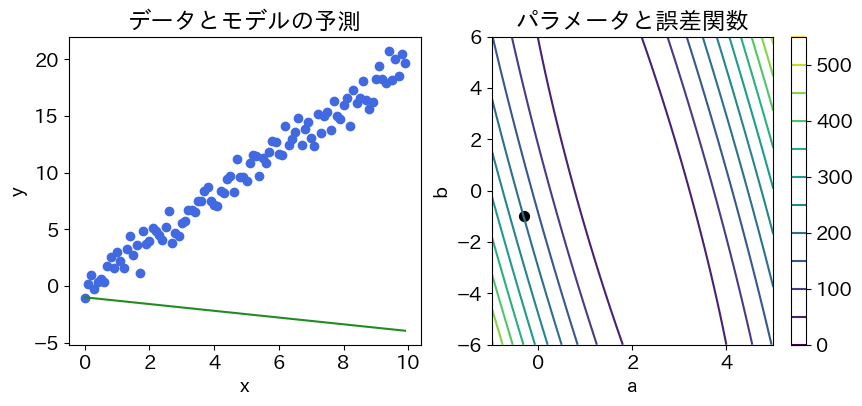

In [3]:
plot_graph()

学習によって求めたいのは、モデル $y = ax + b$ がデータによく当てはまるような $a$ と $b$ の値である。

そのために、モデルのデータに対する当てはまりの悪さを定量する関数である**誤差関数**を用意する[^f4]。誤差関数はモデルのパラメータを引数にとり、モデルの予測誤差を評価した値を返す関数と捉えられる。ここでは**平均二乗誤差**（**Mean Squared Error, MSE**）を誤差関数として採用する。MSEは以下のように定義される：

${\rm{MSE}}(a, b) = \frac{1}{N}\sum_i^N (y_i - (ax_i + b))^2$

上図の右に $a$ と $b$ の値ごとの誤差関数の値の**等高線図**と、最初に設定した $a$ と $b$ のパラメータ値をプロットしている。等高線図は、誤差関数の値が等しい点を結んだ線であり、地形図の等高線のように考えることができる。

誤差関数を設定した後では、学習の目的は「誤差関数をなるべく小さくするようなパラメータを見つけること」と表現できる。勾配法はそのための手法であり、一言で言えば「パラメータを、現在の値から少しずらして誤差関数が最も小さくなる方向に、少しずつ更新する手法」である。ここで、関数の増加速度が最も大きいパラメータの変化方向を**勾配**という。したがって勾配法は「パラメータを誤差関数の勾配の逆方向に少しずつ更新する手法」と言うことができる。

証明は省略するが、数値的には ${\rm{d}}a$、${\rm{d}}b$ を十分小さい値とし、$a$ 方向を <font color="#527DB7">$\left({\rm{MSE}}(a + {\rm{d}}a, b) - {\rm{MSE}}(a, b)\right)/{\rm{d}}a$</font>、$b$ 方向を <font color="#b26145">$\left({\rm{MSE}}(a, b + {\rm{d}}b) - {\rm{MSE}}(a, b)\right)/{\rm{d}}b$</font> としたベクトルが勾配になる。勾配法では、これらを用いて各パラメータを以下のように更新する。

$a \leftarrow a - \alpha$ <font color="#527DB7">$\left({\rm{MSE}}(a + {\rm{d}}a, b) - {\rm{MSE}}(a, b)\right)/{\rm{d}}a$</font>  
$b \leftarrow b - \alpha$ <font color="#b26145">$\left({\rm{MSE}}(a, b + {\rm{d}}b) - {\rm{MSE}}(a, b)\right)/{\rm{d}}b$</font>

ここで $\alpha$ は更新の大きさを決める定数で、**学習率**と呼ばれる。上記の更新を繰り返すと、パラメータは誤差関数を小さくする方向に少しずつ更新される。

Google Colabのノートブック上では、単回帰モデルについて勾配法をインタラクティブに実行できるようにした。「勾配法」と「プロット」を交互に押して、単回帰モデルの予測が改善する様子を確認してみてほしい。

ここでは単回帰モデルを例に、勾配法について解説した。かなり簡単化した説明ではあるが、言語モデルなどの深層学習モデルも原理的にはこれと同じように学習する。

[^f4]: **損失関数**ともいう。また誤差関数・損失関数は最小化したい関数であるが、それとは逆に最大化したい関数のことを**目的関数**という。例えば、誤差関数にマイナスをつけたものを目的関数と考えることができる。これらの用語も知っておくと良いだろう。

### 言語モデルの学習

それでは言語モデルの学習方法について見てみよう。言語モデルの学習は大きく**事前学習**（**Pre-training**）と**事後学習**（**Post-training**）に分けられる。

事前学習では、主にインターネットから集めた大量の文章をデータセットとして、これらの文章をモデルが真似するように $p(w | x;\theta)$ のパラメータ $\theta$ を学習する。例えば、データセットの中に「She reads books in the library.」という文章があったとしよう。このとき言語モデルに文章の途中までを入力したときの次のトークンの生成確率と、実際のトークンを比較するということを繰り返す。具体的には、この文章から以下の6パターンの比較を行う。

- 「She」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「reads」
- 「She reads」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「books」
- 「She reads books」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「in」
- 「She reads books in」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「the」
- 「She reads books in the」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「library」
- 「She reads books in the library」を入力したときの次のトークンの生成確率 $\leftrightarrow$ 「.」

例えば、「She」を入力したときの次のトークンの生成確率はGPT-3なら50257次元のベクトルとなるが、これと「reads」を表すone-hotベクトルの距離を**交差エントロピー**という式により定量化する。言語モデルの学習では、データセットの中からサンプルした文章に対してトークンごとに上で行ったような比較、すなわち交差エントロピーの計算を行い、それらを足したものを誤差関数として学習を行う。これにより言語モデルは、データセットの文章を真似てそれらしい文章を生成できるようになる。

ここで少し立ち止まって事前学習の意味合いについて考えてみよう。事前学習により言語モデルは、大量の文章をただ丸暗記することになるのだろうか。実はそうではなく、言語モデルは事前学習を通じて、文法や一般常識、専門知識、さらに論理的思考力までも身につけると考えられている。例えば、一文一文について次のトークン予測をするためには自然なトークンの並び、すなわち文法を知るのが近道であるし、長文について次のトークン予測をするには過去の文脈を正確に理解することが近道である。また例えばEinstein（アインシュタイン）を様々に表現した文章について、「Einstein」というトークンを予測するためには、Einsteinは何者なのかという一般常識を身につけることが近道である。これらの結果として、言語モデルは丸暗記ではなく、これらの能力を自然と身につけるのだと理解できる。

事前学習を終えると...（TODO）